# Image Stitching using SIFT and RANSAC in Python

## Import Libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Read Images

Image 1:

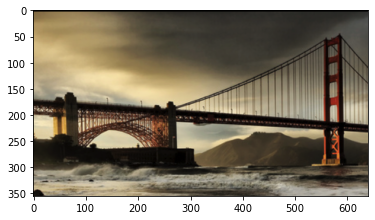

In [2]:
img_1 = cv2.imread("images/assignment3-2a.png", cv2.IMREAD_COLOR)
img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB)
img_1 = img_1[5:360, 10:650]
plt.imshow(img_1)

Image 2:

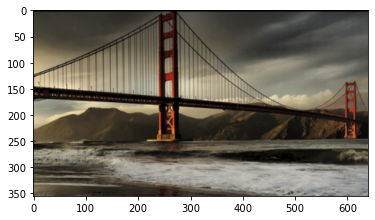

In [3]:
img_2 = cv2.imread("images/assignment3-2b.png", cv2.IMREAD_COLOR)
img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB)
img_2 = img_2[5:360, 10:650]
plt.imshow(img_2)

## SIFT Keypoints and Descriptors

Detection of keypoints and descriptors:

In [4]:
### Initialize a SIFT object
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_1, None)
kp2, des2 = sift.detectAndCompute(img_2, None)

Match keypoints between images:

In [5]:
### Initialize a BFMatcher object
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k = 2)

Apply the ratio test from D. Lowe:

In [6]:
good = []
good_with_list = []
for m, n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)
        good_with_list.append([m])

In [7]:
point_map = np.array([
    [kp1[m.queryIdx].pt[0],
    kp1[m.queryIdx].pt[1],
    kp2[m.trainIdx].pt[0],
    kp2[m.trainIdx].pt[1]] for m in good
])

Draw matches on new image:

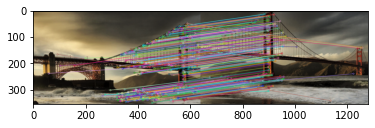

(<matplotlib.image.AxesImage at 0x26f4af38310>, None)

In [8]:
img3 = cv2.drawMatchesKnn(img_1, kp1,
                          img_2, kp2,
                          good_with_list, None,
                          flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

## Estimation of Homography Matrix using RANSAC

Homography from scratch:

In [14]:
### User defined function to compute homography
def computeHomography(pairs):
    A = []
    for x1, y1, x2, y2 in pairs:
        A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])
    A = np.array(A)

    # Singular Value Decomposition (SVD)
    U, S, V = np.linalg.svd(A)

    # V has shape (9, 9) for any number of input pairs. V[-1] is the eigenvector
    # of (A^T)A with the smalles eigenvalue. Reshape into 3x3 matrix.
    H = np.reshape(V[-1], (3, 3))

    # Normalization
    H = (1 / H.item(8)) * H
    return H

### User defined function to calculate geometric distance between point pairs
def dist(pair, H):
    
    # points in homogeneous coordinates
    p1 = np.array([pair[0], pair[1], 1])
    p2 = np.array([pair[2], pair[3], 1])

    p2_estimate = np.dot(H, np.transpose(p1))
    p2_estimate = (1 / p2_estimate[2]) * p2_estimate
    
    return np.linalg.norm(np.transpose(p2) - p2_estimate)


In [20]:
### Find Manual Homography
max_iter = 10000
bestInliers = set()
homography = None

for i in range(max_iter):
    pairs = [point_map[i] for i in np.random.choice(len(point_map), 4)]
    H = computeHomography(pairs)
    inliers = {(c[0], c[1], c[2], c[3]) for c in point_map if dist(c, H) < 3}
    if len(inliers) > len(bestInliers):
            bestInliers = inliers
            homography = H
            if len(bestInliers) > (len(point_map)): break

print(homography)

[[ 1.01735937e+00  9.38476453e-06 -3.20866492e+02]
 [ 4.76605600e-03  1.01860617e+00 -5.04349825e+01]
 [ 2.81029583e-05  1.45448400e-05  1.00000000e+00]]


Homography using OpenCV:

In [12]:
src = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

H, masked = cv2.findHomography(src, dst, cv2.RANSAC)
print(H)

[[ 9.99986570e-01 -2.23523047e-04 -3.15085962e+02]
 [ 8.71444403e-05  9.99756254e-01 -4.69312336e+01]
 [ 2.88538059e-07 -8.54938319e-07  1.00000000e+00]]


Warp image using manually estimated homography matrix:

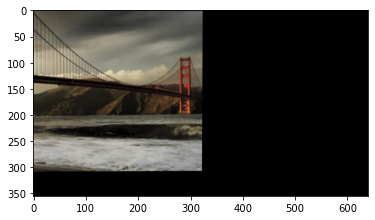

In [21]:
dst = cv2.warpPerspective(img_2, homography, (img_1.shape[1], img_1.shape[0]))
plt.imshow(dst)

Warp image using homography matrix estimated by OpenCV:

In [ ]:
dst = cv2.warpPerspective(img_2, H, (img_1.shape[1], img_1.shape[0]))
plt.imshow(dst)

Stitch images together:

In [ ]:
out = np.zeros((450, img_1.shape[1] * 2, 3))
pad = np.zeros((95, 640, 3))
dst = np.vstack((pad, dst))
print(dst.shape)
out[0:img_1.shape[0], 0:img_1.shape[1], :] = img_1
out[:, 640:1281, :] = dst
out = out[:, 0:1001, :]
out = np.uint8(out)
plt.imshow(out)